In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split

# Flags
PLOT_TRAIN = True
PLOT_TEST = True
PLOT_TEST_LOSS = False
TRAIN_MODEL=True
SAVE_MODEL = True

In [4]:
def load_data(path: str):
    """
    This function loads data from a pickle file located at the provided path.

    Parameters:
        path (str): The path to the pickle file.

    Returns:
        par_comb (np.ndarray): The parameter combinations.
        S11_par (np.ndarray): The best parametric data.
        frequency (np.ndarray): The frequency data.
        degrees (np.ndarray): The degrees data.
        combined_gain (np.ndarray): The combined gain list.
        std_dev (np.ndarray): The standard deviation of Phi.
        efficiency (np.ndarray): The efficiency data.
    """

    with open(path,'rb') as file:
        data_dict = pickle.load(file)
    print(f"Dictionary keys: {data_dict.keys()}")

    par_comb = np.asarray(data_dict['Parameter combination'])
    S11_vals = np.asarray(data_dict['S1,1'])
    frequency = np.asarray(data_dict['Frequency'])
    S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
    degrees = np.asarray(data_dict['degrees'])
    combined_gain = np.asarray(data_dict['combined gain list'])
    std_dev = np.asarray(data_dict['Standard deviation Phi'])
    efficiency = np.asarray(data_dict['efficiency'])
    #efficiency = np.asarray(list(data_dict['efficiency'].values()))
    return par_comb, S11_vals, S11_parametrized, frequency, degrees, combined_gain, std_dev, efficiency

def normalize_data(data_input, mean, std_dev, inverse: bool):
    if inverse:
        data = data_input*std_dev + mean
    else:   
        mean = mean
        std = std_dev
        data = (data_input-mean)/std
    return data


In [5]:
path = 'C:/Users/nlyho/Desktop/MachineLearning/'
par_comb, S11_vals, S11_parameterized, frequency, degrees, combined_gain, std_dev, efficiency = load_data(f"C:/Users/nlyho/OneDrive - Aalborg Universitet/7. semester/Git/MachineLearning/data/simple_wire2_final_with_parametric.pkl")

# Normalize data
par_comb_norm = normalize_data(par_comb,np.mean(par_comb),np.std(par_comb), False)
S11_vals_norm = normalize_data(S11_vals,np.mean(S11_vals),np.std(S11_vals), False)
S11_parameterized_norm = normalize_data(S11_parameterized, np.mean(S11_parameterized),np.std(S11_parameterized), False)
frequency_norm = normalize_data(frequency, np.mean(frequency),np.std(frequency), False)
degrees_norm = normalize_data(degrees, np.mean(degrees),np.std(degrees), False)
combined_gain_norm = normalize_data(combined_gain, np.mean(combined_gain),np.std(combined_gain), False)
std_dev_norm = normalize_data(std_dev, np.mean(std_dev),np.std(std_dev), False)
efficiency_norm = normalize_data(efficiency, np.mean(efficiency),np.std(efficiency), False)


output_vector = par_comb_norm

# input_vector = np.asarray([np.concatenate((S11_vals_norm[i], [std_dev_norm[i]], [efficiency_norm[i]]))for i in range(S11_vals.shape[0])])
input_vector = S11_vals_norm

print(f'Output vector shape: {output_vector.shape}')
print(f'Input vector shape: {input_vector.shape}')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.3, shuffle=True, random_state=42)


std_dev = y_test[:,-2]
efficiency = y_test[:,-1]



Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])
Output vector shape: (2508, 3)
Input vector shape: (2508, 1001)


In [6]:
if TRAIN_MODEL:
    model = keras.Sequential([
        layers.InputLayer(input_shape=(input_vector.shape[1])),
        layers.Dense(256, activation='relu', name = 'layer1'),
        layers.Dense(256, activation='relu', name = 'layer2'),
        layers.Dense(256, activation='relu', name = 'layer3'),
        layers.Dense(256, activation='relu', name = 'layer4'),
    #    layers.Dense(256, activation='relu', name = 'layer5'),
        layers.Dense(output_vector.shape[1], activation = 'linear', name = 'Output_layer')
    ])

    model.summary()


    # Compile the model with the solver adam and the loss function MSE
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.MeanAbsoluteError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )

    #Create lists to store the results
    loss_train = []
    mean_error_train = []
    mean_error_pred = np.zeros(50)
    # Train the model
    model.fit(
        x=input_vector,
        y=output_vector,
        batch_size=100,
        epochs=500,
        shuffle=False,
        callbacks=[keras.callbacks.History()]
    )

    # Define the loss and accuracy for the training and test data
    loss_train.extend(model.history.history['loss'])
    mean_error_train.extend(model.history.history['mean_squared_error'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 256)               256512    
                                                                 
 layer2 (Dense)              (None, 256)               65792     
                                                                 
 layer3 (Dense)              (None, 256)               65792     
                                                                 
 layer4 (Dense)              (None, 256)               65792     
                                                                 
 Output_layer (Dense)        (None, 3)                 771       
                                                                 
Total params: 454659 (1.73 MB)
Trainable params: 454659 (1.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
26/26 [=

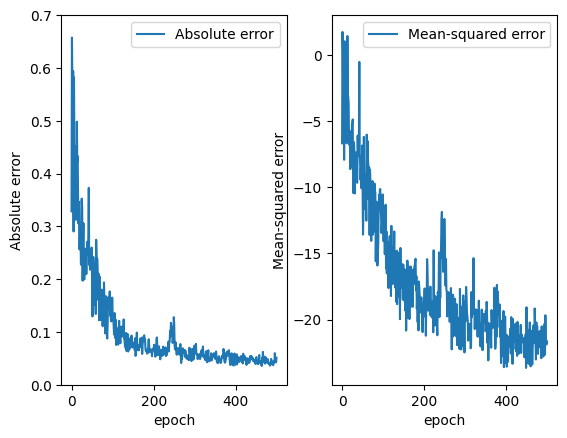

24/24 [==============================] - 0s 1ms/step - loss: 0.0285 - mean_squared_error: 0.0026
y_pred_norm shape: (753, 3)


In [7]:
if PLOT_TRAIN:
    plt.figure()
    plt.subplot(121)
    plt.plot(np.array(loss_train).T)
    plt.ylabel('Absolute error')
    plt.xlabel('epoch')
    plt.legend(['Absolute error'])
    plt.ylim([0, 0.7])
    plt.subplot(122)
    plt.plot(10*np.log10(np.array(mean_error_train).T))
    plt.ylabel('Mean-squared error')
    plt.xlabel('epoch')
    plt.legend(['Mean-squared error'])
    #plt.ylim([0, 0.7])
    plt.show()
    # plt.savefig(f'data/DNN_results_reversal/train_loss/loss_{(j+1)*100}.png')
    # plt.close()
# Run the model on the test data and get the loss and mean-squared error
y_pred_norm = model.predict(X_test)
_ , mean_error_pred = model.evaluate(X_test, y_test)

#Reverse normalization
# Reverse the normalization of the data individually
print(f"y_pred_norm shape: {y_pred_norm.shape}")
y_pred = normalize_data(y_pred_norm, np.mean(par_comb), np.std(par_comb), True)


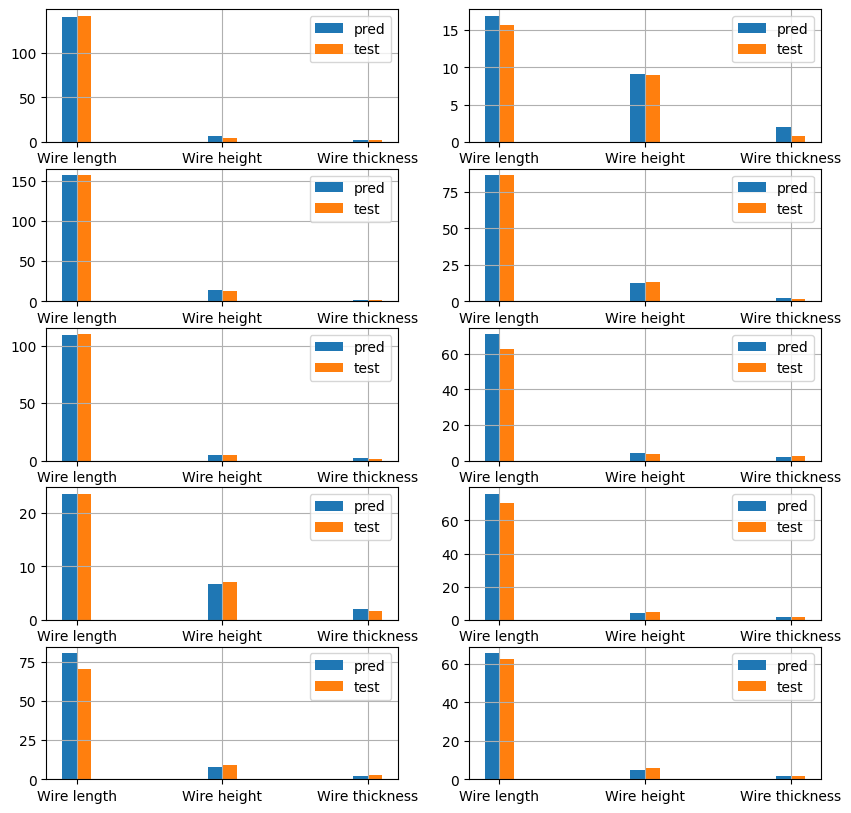

In [17]:
# Plot the testing results
if PLOT_TEST:
    # Make a grouped bar plot with the predicted parameters and the test parameters
    plt.figure(figsize=(10, 10))
    width = 0.1  # the width of the bars
    labels = ["Wire length", "Wire height", "Wire thickness"]
    for i in range(10):
        plt.subplot(5, 2, i+1)
        plt.grid(True)
        bars1 = plt.bar(np.arange(1,4) - width/2, y_pred[i], width)
        bars2 = plt.bar(np.arange(1,4) + width/2, normalize_data(y_test[i],np.mean(par_comb),np.std(par_comb),True), width)
        plt.xticks(np.arange(1,4), labels)
        plt.legend([bars1, bars2], ['pred', 'test'])
        
        
    # plt.figure(figsize=(50, 50))
    # for i in range(10):
    #     plt.subplot(5, 2, i+1)
    #     plt.plot([1,2,3], y_pred[i], "r.")
    #     plt.plot([1,2,3], normalize_data(y_test[i],np.mean(par_comb),np.std(par_comb),True), "b.")
    #     plt.legend(['pred', 'test'])
    #     #plt.ylim([0,15])
    # plt.show()
    # plt.savefig(f'data/DNN_results_reversal/test_pred/test_pred_{j+1}k.png')
    # plt.close()

In [9]:
if SAVE_MODEL:
    model.save('Models/Rev_model_new_1.keras', overwrite=True)

# Test of Reverse model

In [10]:
from keras.models import load_model
import keras
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit

In [11]:
def make_s11_curve(BW, center_freq, frequency, depth, base_line):
    # Define frequency range
    frequency = frequency
    
    def rational_func(x, *args):

        def rational(data, q, p):
            return np.polyval(q, data) / np.polyval(p + [1.0], data)

        # Split the args into poles and zeros
        zeros = args[:len(args)//2]
        poles = args[len(args)//2:]
        #print(poles, zeros)  # Debugging line
        return rational(x, [*zeros], [*poles])

    # Define points for the S11 curve based on BW and center frequency
    points = []
    
    
    depth = depth
    a = (depth-(-10))/(BW/2)
    b1 = depth - a*center_freq
    b2 = depth + a*center_freq
    base_line = base_line
    for i in frequency:

        def in_band(x):
            #print('in band called')
            return a*x + b1 if x < center_freq else -a*x + b2

        #print((-0.2-b2)/(-a))
        #print((-0.2-b1)/(a))
        points.append(in_band(i) if i < (base_line-b2)/(-a) and i > (base_line-b1)/(a) else base_line)
        
    

    #plt.plot(frequency, points, label='S11 box curve')
    zeros = np.linspace(int(10e3),int(10e6), 4)
    poles = np.linspace(int(10e3),int(10e6), 4)

    fitted_curve, cov_matrix, info_d, _, __ = curve_fit(rational_func, frequency, points, p0=[*zeros, *poles], full_output=True)

    S11_curve = rational_func(frequency, *fitted_curve)
    
    plt.plot(frequency, S11_curve, label='S11 fitted curve')
    plt.show()
    return S11_curve

